# N-Body Simulation

An attempt to simulate the N-Body Problem with a reasonable amount of Bodies (Planets). For simplicity, different types such as gas, dark matter etc. are not considered.


In this ipynb, the simulation is shown via matplotlib. The final animation is planned to be visualized by:
* [GlNemo2](https://projets.lam.fr/projects/glnemo2) (on [gitlab.lam.fr](https://gitlab.lam.fr/jclamber/glnemo2)) - A 3D visualization program
* [python-unsio](https://pypi.org/project/python-unsio/) ([projects.lam.fr](https://projets.lam.fr/projects/unsio)) - A python library to generate NBody Snapshots

In [1]:
%matplotlib notebook

# Allows auto-reloading all imports
%load_ext autoreload

In [2]:
%autoreload  # Auto-reload all imports

from collections import namedtuple
from matplotlib import pyplot as plt
from tqdm import tqdm
from random import random
import numpy as np
import scipy.constants

## Parameters
Contains widely used constants for the Simulation, such as `G`, the Gravitational constant or the `TIME_INTERVAL`, used to define the timestep / calculation.

In [3]:
G = scipy.constants.G
TIME_INTERVAL = 5

## Bodies
A body is defined by its name, mass, (initial) position and (initial) velocity. A body is **only** described by its initial position and velocity. The Bodies can be generated randomly or with manual values.

## Numpy Coordinates
To perform the calculations, a `numpy.array` is generated with initial positions and velocities. This array is updated every timestep and should be used for any calculations.
It is a Numpy Float64 array with 3 axes (dimensions):
* List of Bodies
* List of [Position, Velocity]
* List of Coordinates (3DVector, 3*float64)

In [4]:
Body = namedtuple('Body', 'name, mass, position, velocity')


def get_random_bodies(n=2):
    '''
    Generates `n` bodies randomly, with a random mass, position and 0 velocity.
    '''
    def rd_vector(mu): return np.random.normal(mu, 0.2, (3,))

    for i in range(n):
        yield Body(name=f'P{i}', mass=100 * random(), position=rd_vector(0.5), velocity=np.zeros((3,)))

In [5]:
def create_arr_from_bodies(bodies):
    return np.array(tuple((b.position, b.velocity) for b in bodies))

# Function to quickly generate random Position and Velocity Vectors for testing
# def create_random(amount): return np.random.normal(0.5, 0.3, (amount, 2, 3))

# Utility Functions
* Pretty printing coordinates

In [6]:
def pretty_print_coordinates(bodies, arr):
    """
    Pretty Printing Coordinates (Format: `BodyName - (x; y; z)` with 4 decimals)
    """
    for body, x in zip(bodies, arr):
        p = x[0]
        coordinates = '; '.join(f'{p[i]:.4f}' for i in range(3))
        print(f'{body.name} - ({coordinates})')

# Update Function

This is the core of the simulation: the functions that update velocities and positions of all `bodies` for an interval `timestep`.

## Simple Newton
Implementation of Equations derived from "*Newton's laws of motion*" and "*Newton's law of universal gravitation*"


1. Calculate norm of the vector a:
    * Newton's law of motion: $ \vec{F} = m\vec{a}$
    * Newton's law of universal gravitation: \$ F = G \times \frac{m_1 \times m_2}{r^2}$


2. Direction of the vector a: normalized vector \$ \hat r = \frac{\vec r}{\lVert \vec r \rVert}$


$$ m_1 \times \vec a = G \times \frac{m_1 \times m_2}{\lVert \vec r \rVert ^2} \times \hat r $$

$$ \Rightarrow \vec a = G \times \frac{m_2}{\lVert \vec r \rVert ^3} \times \vec r $$

In [7]:
def simple_newton(arr, bodies, timestep=TIME_INTERVAL):
    """
    :param arr: Array of positions and velocities that will be used and updated during calculation
    :param bodies: Iterable of bodies (same length as `arr` that will be used to retrieve mass)
    :param timestemp: The timestep used for one calculation step.
    """
    for idx1, b1 in enumerate(arr):
        acceleration = np.zeros((3,))
        for idx2, b2 in enumerate(arr):

            if idx1 == idx2:
                continue

            d_vec = np.subtract(b2[0], b1[0])
            normalized = d_vec / np.linalg.norm(d_vec)

            r_2 = np.sum(np.power(d_vec, 2))
            m2 = bodies[idx2].mass

            a = G * m2 / r_2
            acceleration += (a * normalized)
        arr[idx1, 1] += acceleration * timestep
    for idx, b in enumerate(arr):
        arr[idx, 0] += b[1] * timestep

# Start of the simulation

Defining Bodies and function to be used, generating array of Positions and starting the matplotlib simulation.

In [8]:
bodies = tuple(get_random_bodies(4))
"""
# Experimenting with hardcoded Values for Bodies
bodies = (
    Body("Sun", 10e10, (0, 0, 0), )
)
"""

# Define function to be used
calc_next_step = simple_newton

In [9]:
# Reset / generate initial position and velocities
arr = create_arr_from_bodies(bodies)
pretty_print_coordinates(bodies, arr)

P0 - (0.4249; 0.8673; 0.3679)
P1 - (0.1036; 0.5917; 0.5638)
P2 - (0.4005; 0.3631; 0.4667)
P3 - (0.5087; 0.7103; 0.5157)


<IPython.core.display.Javascript object>


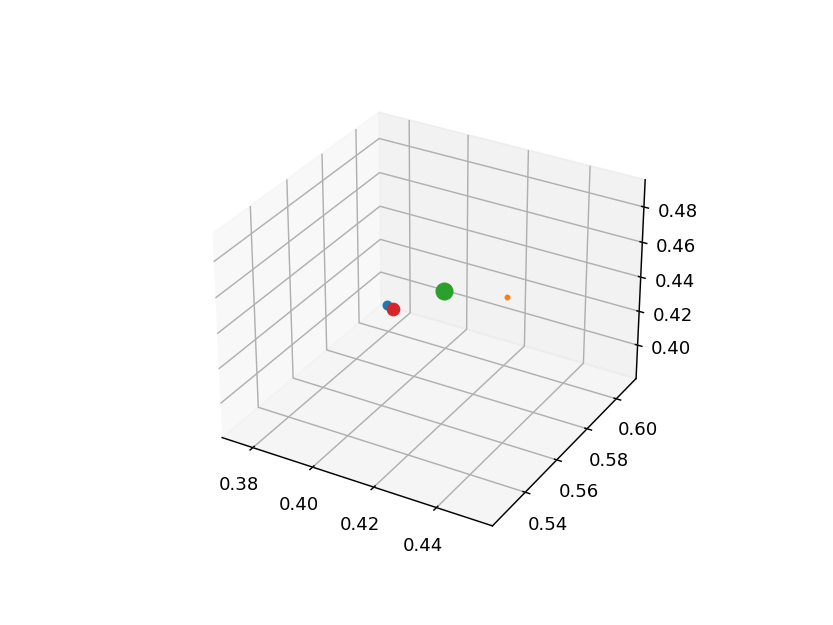



Received SIGINT. Closing simulation

Last Values:
P0 - (0.3751; 0.6080; 0.3873)
P1 - (0.4519; 0.5381; 0.4871)
P2 - (0.4362; 0.5313; 0.4879)
P3 - (0.4235; 0.5260; 0.4764)


In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

try:
    while True:
        calc_next_step(arr, bodies)
        ax.cla()
        
        # Without Loop
#         positions = arr[:, [0]].reshape(-1, 3)
#         xs, ys, zs = positions[:, [0]], positions[:, [1]], positions[:, [2]]
#         ax.scatter(xs, ys, zs, s=tuple(map(lambda b: b.mass, bodies)))

        # With Loop
        for idx, (xs, ys, zs) in enumerate(map(lambda x: x[0], arr[:, [0]])):
            ax.scatter(xs, ys, zs, marker='o', s=bodies[idx].mass)
        fig.canvas.draw()
        fig.show()
except KeyboardInterrupt as e:
    fig.close()
    print(); print()
    print("Received SIGINT. Closing simulation")
    print()
    print("Last Values:")
    pretty_print_coordinates(bodies, arr)

<IPython.core.display.Javascript object>


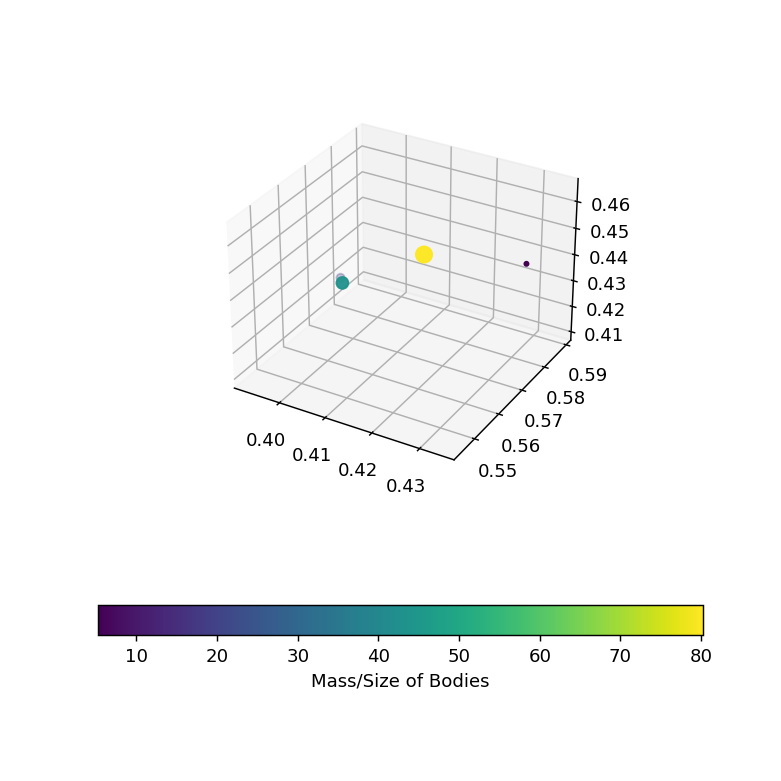

In [12]:
def show_final_with_mass():
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    positions = arr[:, [0]].reshape(-1, 3)
    xs, ys, zs = positions[:, [0]], positions[:, [1]], positions[:, [2]]
    size = tuple(map(lambda b: b.mass, bodies))
    
    r = ax.scatter(xs, ys, zs, s=size, c=size)
    fig.colorbar(r, pad=0.2, orientation='horizontal', label="Mass/Size of Bodies")


show_final_with_mass()